In [104]:
from pathlib import Path

import torch
import numpy as np
from torchvision import models
from sklearn.manifold import TSNE

from cuticulus.datasets import RoughSmoothFull
from cuticulus.console import console

In [105]:
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline

import seaborn as sns
sns.set(font_scale=1.3)

In [106]:
device = torch.device("cuda:5")

In [107]:
model = torch.load(
    Path('./models/resnet101/1651078137/model.pt'),
    map_location=device
)

In [108]:
class ResNet101(models.ResNet):
    def __init__(self, pretrained=True):
        super().__init__(
            block=models.resnet.Bottleneck,
            layers = [3, 4, 23, 3],
            num_classes=2,
        )
        if pretrained:
            self.load_state_dict(model.state_dict())
            
    def _forward_impl(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # Notice there is no forward pass through the original classifier.
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return x

In [109]:
class TorchDS(torch.utils.data.Dataset):
    """Torch dataset class for ant image dataset."""

    def __init__(self, imgs: np.ndarray, labels: np.ndarray):
        """Initialize dataset.

        Args:
            imgs (np.ndarray): List of data.
            labels (np.ndarray): List of labels.
        """
        self.imgs = imgs
        self.labels = labels

    def __len__(self) -> int:
        """Return length of dataset.

        Returns:
            int: Length of dataset.
        """
        return len(self.imgs)

    def __getitem__(self, idx) -> tuple:
        """Return item at index idx.

        Returns:
            tuple: Tuple of image and label.
        """
        return self.imgs[idx], self.labels[idx]

In [110]:
ds = RoughSmoothFull((256, 256))
ds.images = ds.images.transpose(0, 3, 1, 2)
ds.images = ds.images.astype(np.float32)
print(ds.images.shape, ds.labels.shape)

[12:54:28] Loaded labels.                                                       ]8;id=836002;file:///home/ngardn10/anthonyPhan/cuticulus/cuticulus/core/datasets/builder.py\builder.py]8;;\:]8;id=645745;file:///home/ngardn10/anthonyPhan/cuticulus/cuticulus/core/datasets/builder.py#89\89]8;;\

           Loaded dataset.                                                     ]8;id=694100;file:///home/ngardn10/anthonyPhan/cuticulus/cuticulus/core/datasets/builder.py\builder.py]8;;\:]8;id=620466;file:///home/ngardn10/anthonyPhan/cuticulus/cuticulus/core/datasets/builder.py#114\114]8;;\

           Unique images considered: 2499                                      ]8;id=797899;file:///home/ngardn10/anthonyPhan/cuticulus/cuticulus/core/datasets/builder.py\builder.py]8;;\:]8;id=462652;file:///home/ngardn10/anthonyPhan/cuticulus/cuticulus/core/datasets/builder.py#135\135]8;;\

           Samples per class:                                                  ]8;id=171796;file:///home/ngardn10/anthonyPhan/cuticulus/cuticulus/core/datasets/builder.py\builder.py]8;;\:]8;id=886601;file:///home/ngardn10/anthonyPhan/cuticulus/cuticulus/core/datasets/builder.py#128\128]8;;\

           0: 1072                                                             ]8;id=206879;file:///home/ngardn10/anthonyPhan/cuticulus/cuticulus/core/datasets/builder.py\builder.py]8;;\:]8;id=787555;file:///home/ngardn10/anthonyPhan/cuticulus/cuticulus/core/datasets/builder.py#131\131]8;;\

           1: 1427                                                             ]8;id=520376;file:///home/ngardn10/anthonyPhan/cuticulus/cuticulus/core/datasets/builder.py\builder.py]8;;\:]8;id=86590;file:///home/ngardn10/anthonyPhan/cuticulus/cuticulus/core/datasets/builder.py#131\131]8;;\

(2499, 3, 256, 256) (2499,)


In [111]:
model_2 = ResNet101()
model_2.to(device)

ResNet101(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(

In [112]:
data_loader = torch.utils.data.DataLoader(
    dataset=TorchDS(ds.images, ds.labels),
    batch_size=16,
    shuffle=False
)

res_images = []
res_labels = []
preds_list = []
for inputs, labels in data_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model_2(inputs)
    
    _, preds = torch.max(model(inputs), 1)
    preds_list.append(preds.cpu().numpy())
    res_images.append(outputs.cpu().detach().numpy())
    res_labels.append(labels.cpu().detach().numpy())

res_images = np.concatenate(res_images, axis=0)
res_labels = np.concatenate(res_labels, axis=0)
preds_list = np.concatenate(preds_list, axis=0)

In [113]:
tsne = TSNE(n_components=2).fit_transform(res_images)
# normalize to [0, 1]
tsne = (tsne - tsne.min()) / (tsne.max() - tsne.min())
# randomly subsample to avoid overplotting
idx = np.random.choice(tsne.shape[0], size=1000, replace=False)
tsne = tsne[idx]

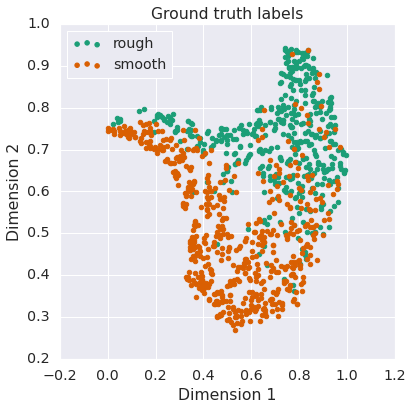

In [114]:
def ground_truth():

    # plot the simplified dataset
    fig, ax = plt.subplots()
    label_map = {
        0: 'rough',
        1: 'smooth',
    }
    fig.set_size_inches(6, 6)

    for label in [0, 1]:
        idx2 = np.where(res_labels[idx] == label)[0]
        ax.scatter(tsne[idx2, 0], tsne[idx2, 1], label=label_map[label], color=sns.color_palette("Dark2")[label])

    ax.set_title('Ground truth labels')
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    ax.legend(loc='best')

    fig.show()
    plt.savefig(Path('./plots/resnet101_gt_tsne.png'))
ground_truth()

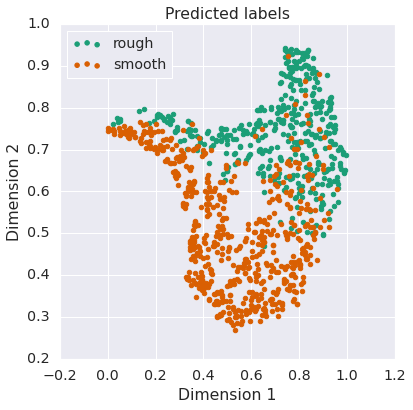

In [115]:
def predicted_plot():
    # plot the simplified dataset
    fig, ax = plt.subplots()
    label_map = {
        0: 'rough',
        1: 'smooth',
    }
    fig.set_size_inches(6, 6)

    for label in [0, 1]:
        idx2 = np.where(preds_list[idx] == label)[0]
        ax.scatter(tsne[idx2, 0], tsne[idx2, 1], label=label_map[label], color=sns.color_palette("Dark2")[label])

    ax.set_title('Predicted labels')
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    ax.legend(loc='best')

    fig.savefig(Path('./plots/resnet101_pred_tsne.png'))
    plt.show()
    
predicted_plot()